### 회귀실습- 캐글 주택 가격: 고급 회귀 기법

미국 아이오와 주의 에임스 지방의 주택가격 정보

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

- 머신러닝은 특성공학이 중요
- 과적합 피하고 일반화된 모델을 만들기 위해서 데이터 분리, 속성 줄이기, 정규화, 검증
- feature engineering 특성 공학 = 전처리
- 샘플 많아지면 (데이터 양 커지면) 과대적합 피할 수 있음
-  ->> 과적합 피하기위해 : 샘플 크게 - 피처개수 줄이기 - 2차검증(규제) 등

Q. 상기 데이터로 아래 사항에 유의하여 다음 사항을 수행하세요.

- LinearRegression, Ridge, Lasso를 이용하여 모델링 및 평가
    - 평가는 RMSLE(가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높은 것을 상쇄하기 위하여 오류 값을 로그 변환하여 평가)
    - Null이 많은 컬럼과 불필요한 컬럼 삭제
    - 삭제하지 않은 숫자형 컬럼은 평균값으로 대체
    - 문자형 피처는 원-핫인코딩으로 변환
    - 피처별 회귀 계수 시각화 및 모델별 비교 
    - 교차검증 수행 후 모델별 비교 - cross_val_score 이용 
    - 각 모델별 평가 결과 비교 분석 및 개선 방안 기술
- Ridge와 Lasso 모델에 대하여 하이퍼 파라미터 튜닝하면서 최적 값 도출 후 학습/예측/평가 수행 및 회귀 계수 시각화 (릿지 랏쏘 : 규제가하는 것~)
- 피처 데이터 세트의 분포도 검토 후 로그 변환 및 종속변수와 상관관계가 높은 독립변수의 이상치를 제거 후 학습/예측/평가 수행 및 시각화
- 회귀 트리 모델을 이용해 학습/예측/평가 수행 및 피처 중요도 시각화 ( 회귀모델말고 회귀트리모델로 수행해보기)

In [42]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df= pd.read_csv('dataset/house_price.csv')
house_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [43]:
house_df.shape

(1460, 81)

In [44]:
# 전체 피처 type 확인 
house_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [45]:
# null 있는 columns
house_df.isnull().sum()[house_df.isnull().sum()>0].sort_values(ascending=False)

# >> 3분의1 이상이 null이면 drop  >> PoolQC, MiscFeature, Alley, Fence, FireplaceQu 
# 나머지는 평균값대체

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [46]:
# SalePrice 기준 상관관계 내림차순
house_df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [47]:
# def get_corr(df, upper_condition_n, most_up_condition_n):
#     cr = df.corr()
#     plt.figure(figsize=(10,10))
#     print(sns.heatmap(cr,annot=True))
#     cr_p = cr.unstack()
#     cr_v = cr_p.sort_values(kind='quicksort')
#     print('\n',cr_v,'\n')
#     cond = cr_v[(upper_condition_n<abs(cr_v)) & (most_up_condition_n > abs(cr_v))].keys()
#     print(dict(cond).keys())
    
# get_corr(house_df,0.9,1) # 0.7~1 

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

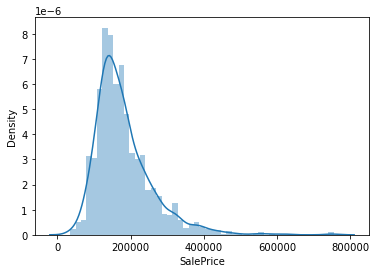

In [48]:
# 종속변수 분포 확인
sns.distplot(house_df['SalePrice'])

# >> 정규분포라고 하기 어려움 (왼쪽으로 쏠려있다)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

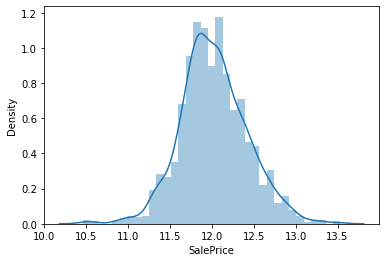

In [49]:
# 로그변환 - 정규분포 만들어주기
log_SalePrice = np.log1p(house_df['SalePrice'])

# 로그변환 후 분포 확인
sns.distplot(log_SalePrice)

# >> 정규분포! 

In [50]:
# 로그변환한 SalePrice 데이터프레임에 넣어주기

house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [51]:
# 필요없는 columns 삭제 (Id, null값 3분의1 이상이었던 columns)
house_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','Id'],axis=1,inplace=True)

In [52]:
# 나머지 columns에서  숫자형 columns null값 평균값으로 대체 
house_df.fillna(house_df.mean(),inplace=True)

# >> but, 문자형인 column에는 null값 존재

In [53]:
# 문자형 columns - one_hot 인코딩
house_df_oh= pd.get_dummies(house_df)

print('shape: ', house_df_oh.shape)
print('null 개수: ', house_df_oh.isnull().sum().sum())

shape:  (1460, 271)
null 개수:  0


In [55]:
# 이미 종속변수가 로그 변환 -> RMSE만 적용하면 RMSLE 자동 측정 
# 선형 회귀 모델

# RMSE 계산 사용자함수
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print('{0} 로그변환된 RMSE(RMSLE): {1}'.format(model.__class__.__name__,np.round(rmse,3)))
    return rmse

# get_rmse 사용자함수 사용해서 여러모델 RMSE값 반환
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses



In [56]:
# 선형회귀모델 학습- 예측평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_oh['SalePrice'] # log변환된 y 
X_features = house_df_oh.drop('SalePrice',axis=1)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                    test_size=0.2, random_state=156)
# 모델별 학습
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

models= [lr, ridge, lasso]

for model in models:
    model.fit(X_train,y_train)

# 사용자함수로 RMSE 반환 >> 다시한번 알아두기 : 로그변환된거라 RMSE => RMSLE 
get_rmses(models)

# >> Lasso만 0.176으로 lr,ridge 보다 성능이 떨어짐 >> 하이퍼파라미터 튜닝으로 개선

LinearRegression 로그변환된 RMSE(RMSLE): 0.132
Ridge 로그변환된 RMSE(RMSLE): 0.128
Lasso 로그변환된 RMSE(RMSLE): 0.176


[0.1318957657915436, 0.12750846334053045, 0.17628250556471395]

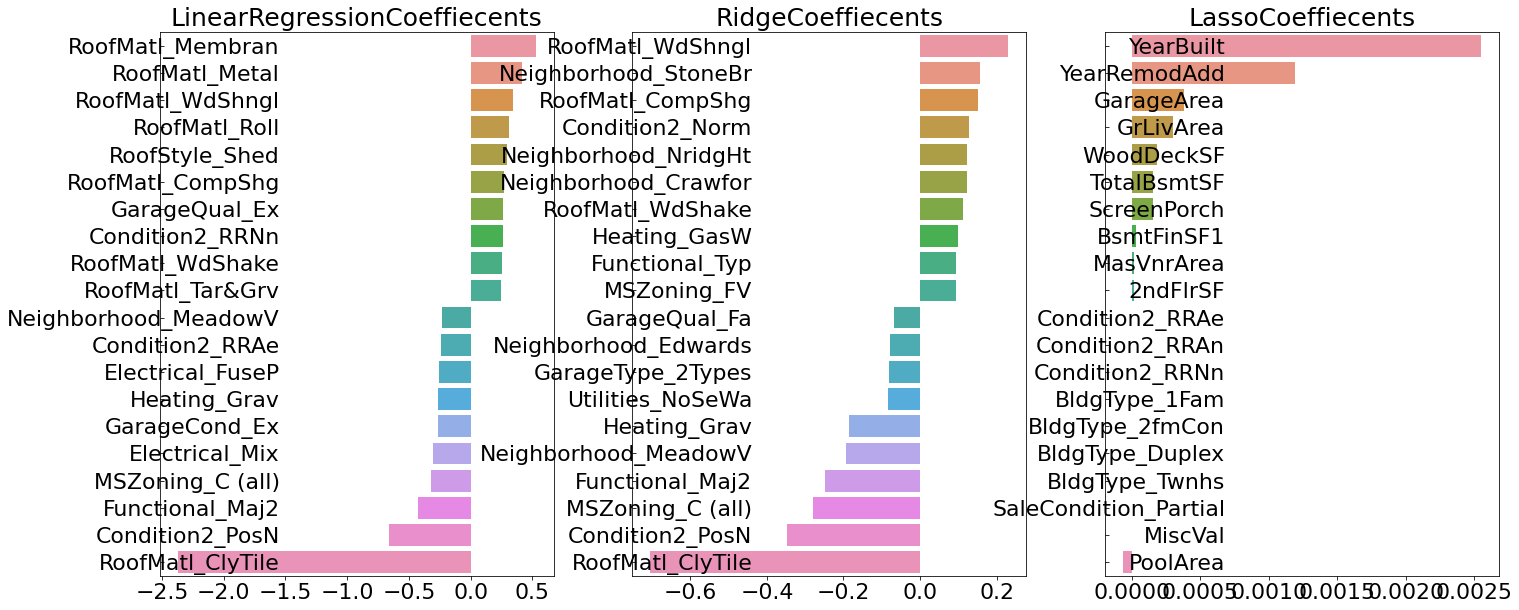

In [57]:
# feature별 회귀계수 시각화 (모델별 구성 feature 회귀계수)
# 상위10 + 하위10

# 모델별 회귀계수 사용자함수
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체 생성, index 컬럼명
    coef= pd.Series(model.coef_, index=X_features.columns) 
    
    # 상위10개 하위10개
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

# 모델별 회귀계수 사용자함수 -> 시각화 사용자함수
def visualize_coefficient(models):
    # lr, ridge, lasso 3개 시각화 >> subplot 3개 컬럼 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    
    # models에서 lr, ridge, lasso 하나씩 뽑아서 회귀계수 뽑기
    for i, model in enumerate(models):
        # get_top_bottom_coef 사용자함수로 상하위 10개씩 회귀계수 뽑기
        coef_high, coef_low = get_top_bottom_coef(model)
        # 상위 하위 뽑은것 합치기
        coef_concat = pd.concat([coef_high, coef_low])
        
        # 순차적으로 ax subplot에 barchar로 나타내기 (시각화 설정)
        # (tick label 위치, font 크기 설정 --> 한 화면에 표현하려고)
        axs[i].set_title(model.__class__.__name__+ 'Coeffiecents', size=25) # 타이틀 설정
        axs[i].tick_params(axis="y",direction="in", pad=-120) # y축을 기준으로, 안쪽방향,
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)  # x,y축에 들어가는 애들 폰트 크기설정
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax= axs[i])
        # x: 상위하위 values값 | y: index컬럼명 | [i]모델명 순서대로
        
        
# 사용자함수 사용해서 models 시각화
visualize_coefficient(models)

# >> 회귀계수 sorting된 순서가 다 다르다
# >> Lasso만 회귀계수 값들이 적음 + YearBuilt만 엄청 큼  >> WHY? 

In [58]:
# lasso WHY?  >> 학습 데이터 분할이 잘못되었을 수도 있음
# 분할 말고 cv(교차검증)로 평균 RMSE 측정해보기 


from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # MSE score -> RMSE score 
        # cv=5 교차검증 + neg_mean~ 사용하면 음수값으로 나오니까
        # 마이너스 붙여줘서 양수값으로 변환하고 루트씌우기
        cross_score = cross_val_score(model, X_features,y_target,
                                      scoring='neg_mean_squared_error', cv=5) 
        rmse_score = np.sqrt(-1*cross_score)
        # RMSE 평균 
        rmse_avg = np.mean(rmse_score) 
        
        print('\n{0} CV RMSE 값 :: {1}'.format(model.__class__.__name__, rmse_score.round(3)))
        print('{0} CV 평균 RMSE 값 :: {1}'.format(model.__class__.__name__, rmse_avg.round(3)))
    
# get_avg_rmse_cv 로 lr, ridge, lasso 의 CV RMSE값 뽑기
get_avg_rmse_cv(models)

# >> 교차검증을 해도 lasso가 성능이 더 떨어진다. -> 테스트 분할이 잘못된 것은 아님
# >> 게다가 전체적으로 다 성능이 저하됨


LinearRegression CV RMSE 값 :: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값 :: 0.155

Ridge CV RMSE 값 :: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 :: 0.144

Lasso CV RMSE 값 :: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 :: 0.198


In [99]:
# Ridge, Lasso의 alpha 하이퍼 파라미터 최적화 사용자함수

from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model= GridSearchCV(model, param_grid=params,
                            scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features, y_target)
    # neg~ 로 반댓값 된 것을 양수로 돌려주고 루트 -> RMSE 
    rmse= np.sqrt(-1*grid_model.best_score_) # rmse에서 젤 점수 좋은 것
    
    print('< {0} [cv=5]일 때 >\n최적의 평균 RMSE 값 :: {1}\n최적의 alpha값 :: {2}\n'.format(
            model.__class__.__name__, rmse.round(4), grid_model.best_params_))
    return grid_model.best_estimator_



In [100]:
# params 설정해주고 하이퍼파라미터 최적화 사용자함수 사용

ridge_params = { 'alpha':[1, 5, 8, 10, 12, 15, 18, 20]}
lasso_params = { 'alpha':[0.0005, 0.0008, 0.001, 0.005, 0.008, 0.01, 0.05, 0.08, 0.1]}

print_best_params(ridge,ridge_params)
print_best_params(lasso,lasso_params)

# >> 예측성능 거의 똑같아지고 Lasso 성능도 개선됨

< Ridge [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1125
최적의 alpha값 :: {'alpha': 8}

< Lasso [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1099
최적의 alpha값 :: {'alpha': 0.0005}



Lasso(alpha=0.0005)

LinearRegression 로그변환된 RMSE(RMSLE): 0.129
Ridge 로그변환된 RMSE(RMSLE): 0.103
Lasso 로그변환된 RMSE(RMSLE): 0.101


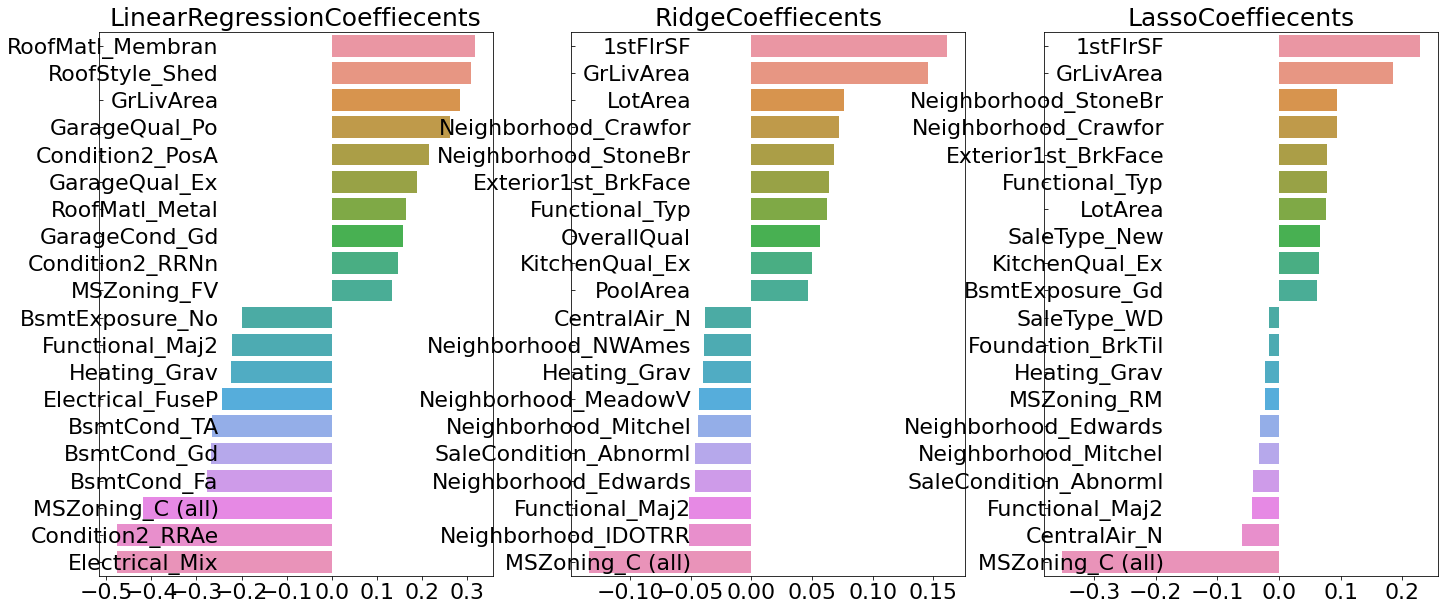

In [101]:
# 최적화된 alpha값으로 학습

lr_ =LinearRegression()
lr_.fit(X_train,y_train)

ridge_ = Ridge(alpha=12)
ridge_.fit(X_train,y_train)

lasso_ = Lasso(alpha=0.0005)
lasso_.fit(X_train,y_train)

# RMSE 출력
models= [lr_, ridge_, lasso_]
get_rmses(models)

# 회귀계수 시각화
visualize_coefficient(models)


# >> 성능 많이 개선됨
# >> 여전히 Lasso의 feature들 회귀계수가 낮지만, Ridge와 Lasso의 feature별 비율이 비슷해졌다

# alpha값 : 규제 강도

In [102]:
# 지나치게 왜곡된 feature가 있으면 회귀 예측성능을 저하 시킬 수 있다.
# skew > 1 이면 왜곡이 심하다고 판단 
# skew : 데이터 분포의 대칭성의 결핍 정도 
# -0.5 ~ 0,5 : 대칭적
# -1~-0.5 또는 0.5~1 : 적당히 치우침 
# -1 이하 또는 1 이상 : 상당히 치우침 

In [103]:
# 1 이상의 왜곡 정도를 보이는 feature에 로그 변환을 적용
# one-hot 인코딩된 feature는 제외 : 카테고리화 된 피처는 왜곡 가능성 높음

from scipy.stats import skew 

# 숫자형 feature column index 추출
feature_index = house_df.dtypes[house_df.dtypes != 'object'].index

# 각 feature column 데이터셋에 skew 적용
skew_features= house_df[feature_index].apply(lambda x: skew(x))

# skew 가 -1 이하 1 이상인 것 추출 
skew_features_top = skew_features[skew_features > 1]
skew_features_down = skew_features[skew_features < -1]

# skew_features_top.index
# skew_features_down.index  --> 하나도 없음 -> top만 사용하자

# (skew 1 이상인) skew_features_top 로그변환 
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])



In [104]:
# one-hot인코딩 적용해서 데이터 분할
house_df_oh= pd.get_dummies(house_df)

X_features = house_df_oh.drop('SalePrice', axis=1)
y_target = house_df_oh['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)

# 최적의 RMSE와 최적의 하이퍼 파라미터 출력
ridge_params = { 'alpha':[1, 5, 8, 10, 12, 15, 18, 20]}
lasso_params = { 'alpha':[0.0005, 0.0008, 0.001, 0.005, 0.008, 0.01, 0.05, 0.08, 0.1]}

print_best_params(ridge,ridge_params)
print_best_params(lasso,lasso_params)


< Ridge [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1275
최적의 alpha값 :: {'alpha': 10}

< Lasso [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1237
최적의 alpha값 :: {'alpha': 0.0005}



Lasso(alpha=0.0005)

LinearRegression 로그변환된 RMSE(RMSLE): 0.129
Ridge 로그변환된 RMSE(RMSLE): 0.121
Lasso 로그변환된 RMSE(RMSLE): 0.116


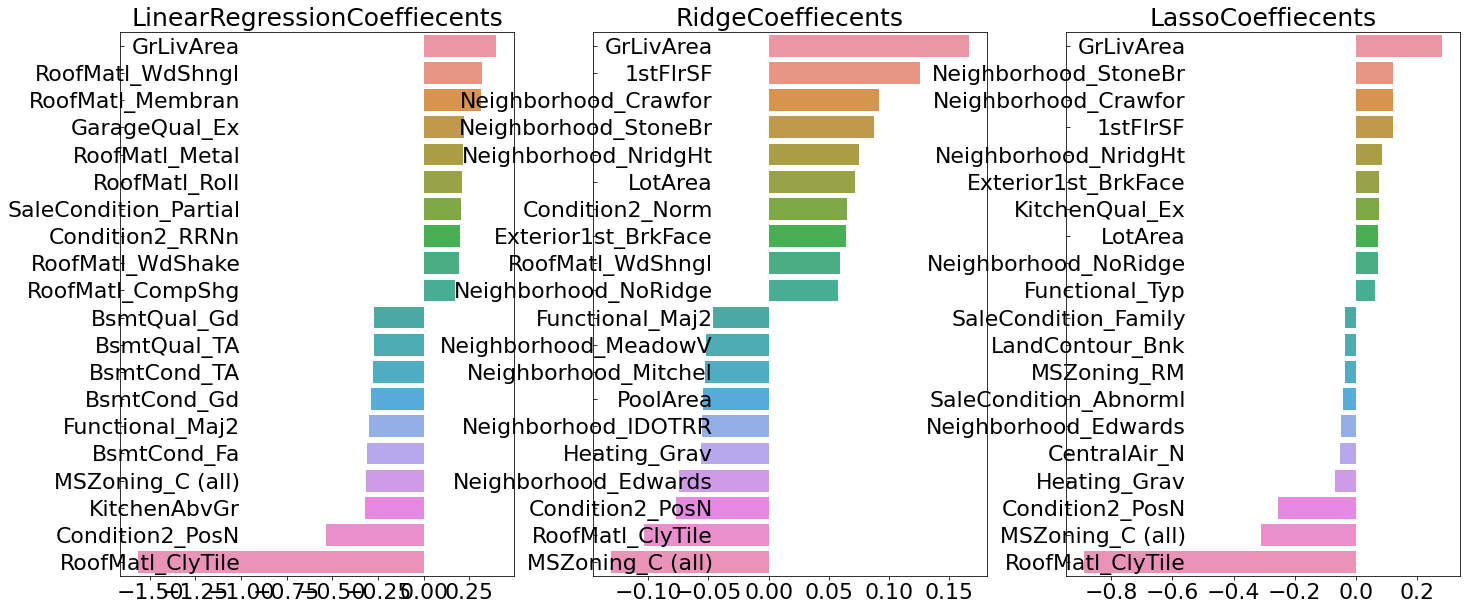

In [105]:
# 최적화된 alpha값으로 학습

lr_ =LinearRegression()
lr_.fit(X_train,y_train)

ridge_ = Ridge(alpha=10)
ridge_.fit(X_train,y_train)

lasso_ = Lasso(alpha=0.0005)
lasso_.fit(X_train,y_train)

# RMSE 출력
models= [lr_, ridge_, lasso_]
get_rmses(models)

# 회귀계수 시각화
visualize_coefficient(models)

# >> GrLivArea 공간 크기가 주택 가격에 미치는 영향이 가장 클 것이라는 결과 도출

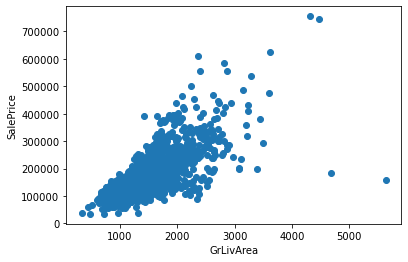

In [106]:
# 이상치 데이터 분석 (회귀계수가 높은 feature 이상치 처리)

house_df_2= pd.read_csv('dataset/house_price.csv')
house_df_2.head(2)

# ( 원본 데이터에서 ) GrLivArea의 데이터 분포 
plt.scatter(x=house_df_2['GrLivArea'] , y= house_df_2['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

# >> 양의 상곤관계를 갖는다 
# >> but, 공간은 가장 넓은데 가격은 매우 낮은 데이터 = 이상치 

In [107]:
# 로그변환한 house_df_oh에 반영 
cond1 = house_df_oh['GrLivArea'] > np.log1p(4000) # 공간크기가 4000보다 높은
cond2 = house_df_oh['SalePrice'] < np.log1p(500000) # 가격이 500000보다 낮은

# 이상치 = 공간크기가 4000보다 넓은데 가격은 500000보다 낮은 것 
outlier_index = house_df_oh[cond1 & cond2].index  # 이상치 있는ㄴ index 

# 이상치 제거
house_df_oh.drop(outlier_index , axis=0, inplace=True)



In [108]:
# 바뀐 데이터로 다시 최적화

y_target = house_df_oh['SalePrice']
X_features = house_df_oh.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)

ridge_params = { 'alpha':[1, 5, 8, 10, 12, 15, 18, 20]}
lasso_params = { 'alpha':[0.0005, 0.0008, 0.001, 0.005, 0.008, 0.01, 0.05, 0.08, 0.1]}
best_ridge = print_best_params(ridge, ridge_params)
best_lasso = print_best_params(lasso, lasso_params)

< Ridge [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1125
최적의 alpha값 :: {'alpha': 8}

< Lasso [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1099
최적의 alpha값 :: {'alpha': 0.0005}



LinearRegression 로그변환된 RMSE(RMSLE): 0.129
Ridge 로그변환된 RMSE(RMSLE): 0.103
Lasso 로그변환된 RMSE(RMSLE): 0.101


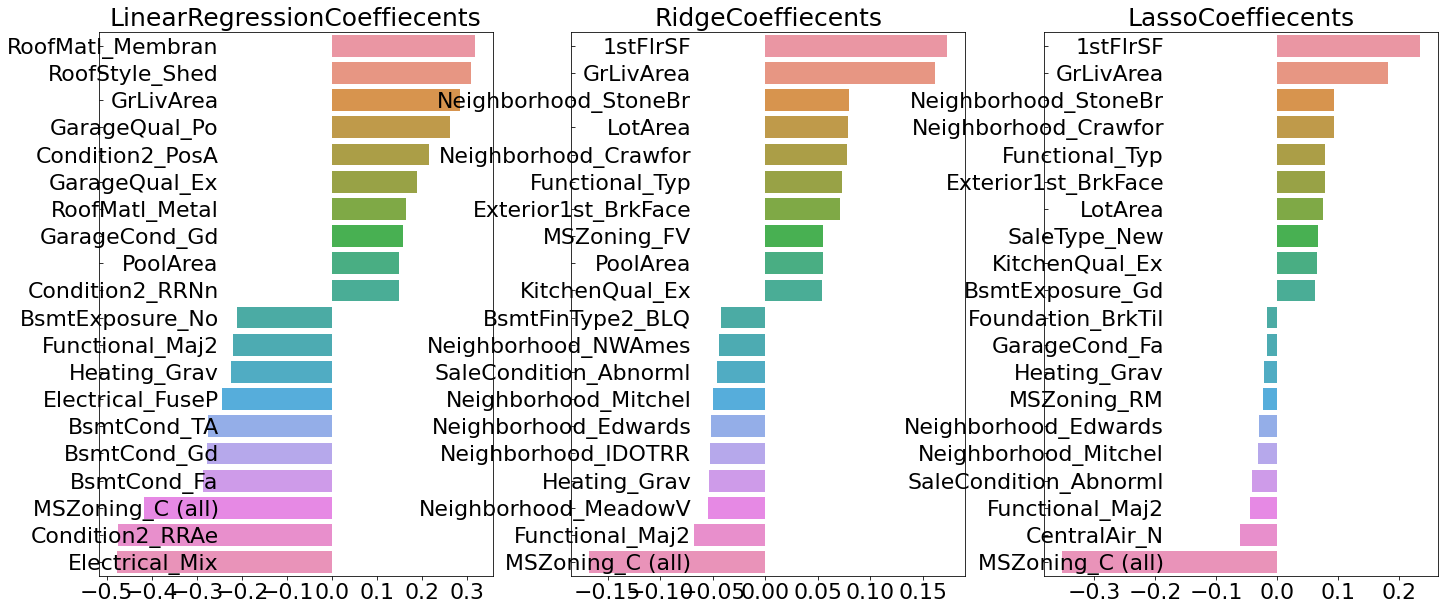

In [109]:
# 최적화된 alpha값으로 학습

lr_ =LinearRegression()
lr_.fit(X_train,y_train)

ridge_ = Ridge(alpha=8)
ridge_.fit(X_train,y_train)

lasso_ = Lasso(alpha=0.0005)
lasso_.fit(X_train,y_train)

# RMSE 출력
models= [lr_, ridge_, lasso_]
get_rmses(models)

# 회귀계수 시각화
visualize_coefficient(models)

# >> 이상치 2개 삭제 -> RMSE 0.015 이상 줄어듦 

In [110]:
# 회귀트리 모델 학습, 예측평가

In [111]:
# lgbm이 규제를 주지않아도 ... 값이 잘나옴
# why: 오류가 나는것에 패널티를 가하기때문에 
# 회귀는 회귀계수로 비교하지만, 회귀트리에는 회귀계수가 없어서 중요도로 뽑아줌

In [112]:
# XGBoost 회귀트리

from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)
best_xgb

< XGBRegressor [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1178
최적의 alpha값 :: {'n_estimators': 1000}



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
# LightGBM 회귀트리

from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)
best_lgbm

< LGBMRegressor [cv=5]일 때 >
최적의 평균 RMSE 값 :: 0.1163
최적의 alpha값 :: {'n_estimators': 1000}



LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, n_estimators=1000,
              num_leaves=4, reg_lambda=10, subsample=0.6)

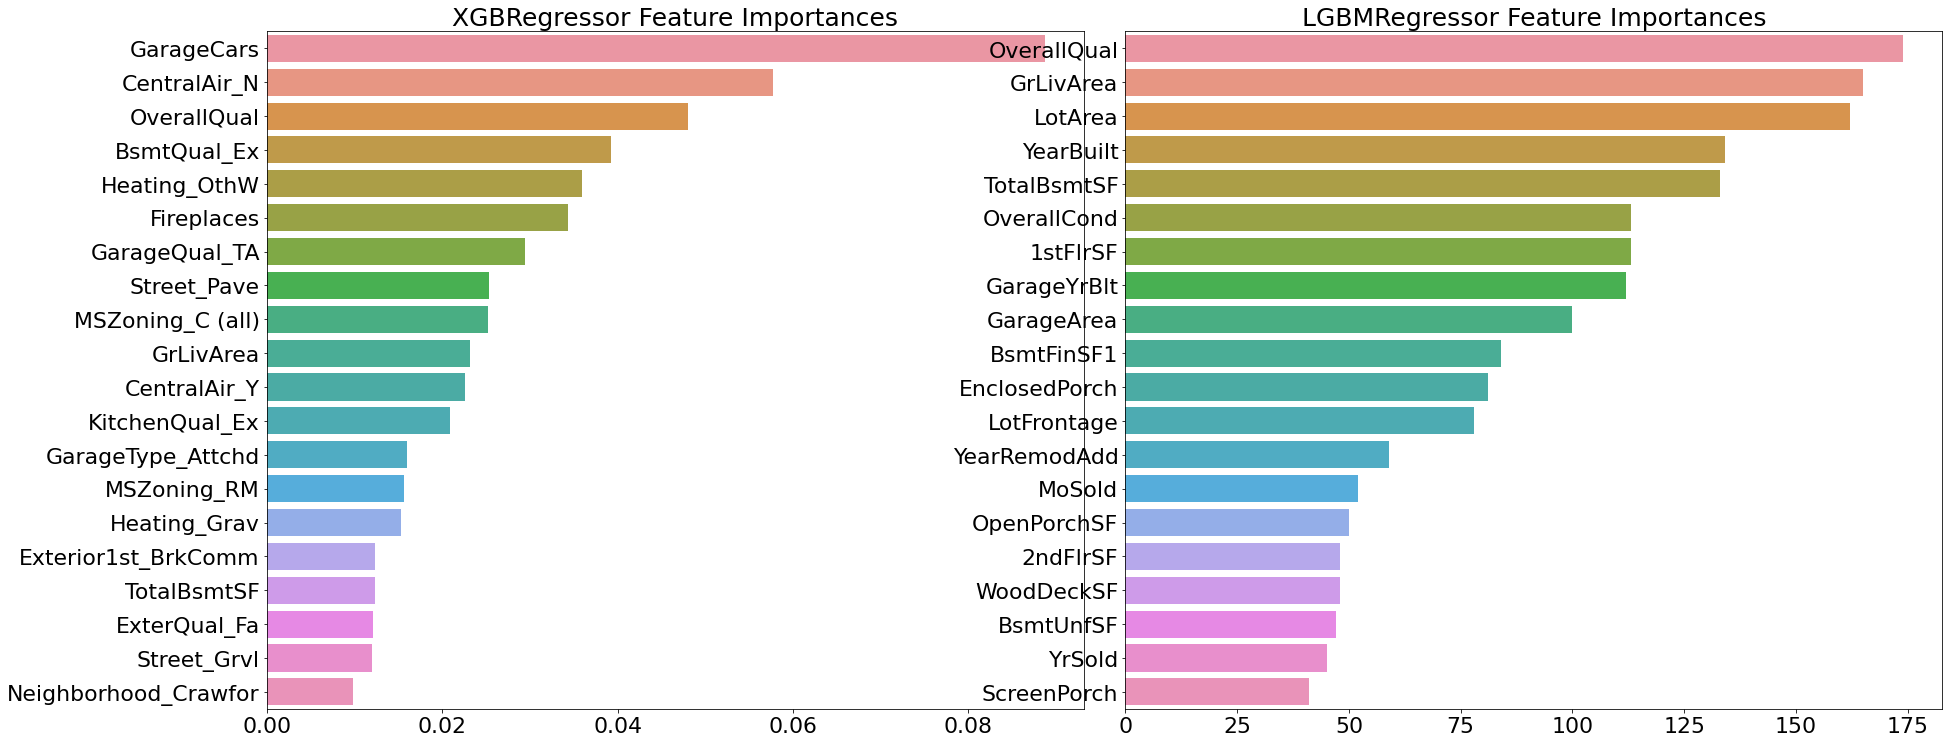

In [118]:
# 변수 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    

models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

In [119]:
# 회귀 모델의 예측 결과 혼합을 통한 최종 예측 

def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse= mean_squared_error(y_test,pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 rmse: {1}'.format(key,rmse))
        
# 개별 모델의 학습 
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

# 개별 모델 예측 
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# preds = {'Ridge':ridge_pred, 'Lasso':lasso_pred}
# get_rmse_pred(preds)

# 혼합으로 최종 예측값 도출
pred = 0.4*ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합': pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}
get_rmse_pred(preds)

최종 혼합 모델의 rmse: 0.09966514052353531
Ridge 모델의 rmse: 0.10288980218833532
Lasso 모델의 rmse: 0.10001446974492108


In [120]:
# Q. XGBRegressor와 LGBMRegressor를  5:5로 혼합하여 예측값 도출
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgb_reg= XGBRegressor(n_estimators=1000, learning_rate=0.05,
                     colsample_bytree=0.5,subsample=0.8)
lgbm_reg= LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                     subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)


# 개별 모델의 학습 
xgb_reg.fit(X_train,y_train)
lgbm_reg.fit(X_train,y_train)

# 개별 모델 예측 
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)


# 혼합으로 최종 예측값 도출
pred = 0.4*xgb_pred + 0.6*lgbm_pred
preds = {'최종 혼합': pred,
        'Ridge': xgb_pred,
        'Lasso': lgbm_pred}
get_rmse_pred(preds)

최종 혼합 모델의 rmse: 0.10149086181038681
Ridge 모델의 rmse: 0.10738295638346222
Lasso 모델의 rmse: 0.10382510019327311
